In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ewliDV5uinYOrQP2Ut1S")
project = rf.workspace("test2-ilbvs").project("warehouse-nmztp")
version = project.version(1)
dataset = version.download("yolov9")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to warehouse-1 in yolov9:: 100%|██████████| 24508/24508 [00:06<00:00, 3598.78it/s]


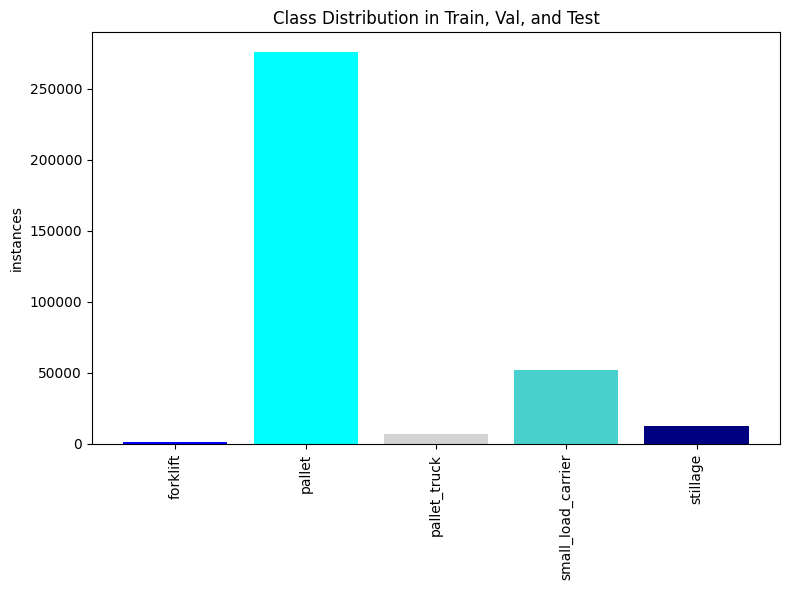

In [2]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Define paths to YOLOv8 labels for all splits
base_path = '/content/warehouse-1'
splits = ['train', 'valid', 'test']

# Define your class names (must match the order in your YOLO dataset)
class_names = [
    'forklift',
    'pallet',
    'pallet_truck',
    'small_load_carrier',
    'stillage'
]

# Count class instances from all splits
class_counts = Counter()

for split in splits:
    labels_dir = os.path.join(base_path, split, 'labels')
    if not os.path.exists(labels_dir):
        print(f"Warning: {labels_dir} not found, skipping...")
        continue
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1

# Map counts to class names
class_counts_named = {class_names[k]: class_counts.get(k, 0) for k in range(len(class_names))}

# Plotting
colors = ['blue', 'cyan', 'lightgray', 'mediumturquoise', 'navy']
plt.figure(figsize=(8, 6))
plt.bar(class_counts_named.keys(), class_counts_named.values(), color=colors)
plt.ylabel("instances")
plt.xticks(rotation=90)
plt.title("Class Distribution in Train, Val, and Test")
plt.tight_layout()
plt.show()


In [7]:
import os
import shutil
import random
from collections import Counter

# ========== CONFIG ==========
SOURCE_ROOT = '/content/warehouse-1'
TARGET_ROOT = '/content/balanced_Data'
SPLITS = ['train', 'valid', 'test']
KEEP_CLASSES = {1, 3, 4}
TARGET_COUNTS = {1: 12000, 3: 12000, 4: 12337}
CLASS_NAMES = {1: 'pallet', 3: 'small_load_carrier', 4: 'stillage'}

def ensure_dirs():
    for split in SPLITS:
        os.makedirs(os.path.join(TARGET_ROOT, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(TARGET_ROOT, split, 'labels'), exist_ok=True)

def process_split(split, current_counts):
    src_lbl_dir = os.path.join(SOURCE_ROOT, split, 'labels')
    src_img_dir = os.path.join(SOURCE_ROOT, split, 'images')
    tgt_lbl_dir = os.path.join(TARGET_ROOT, split, 'labels')
    tgt_img_dir = os.path.join(TARGET_ROOT, split, 'images')

    label_files = [f for f in os.listdir(src_lbl_dir) if f.endswith('.txt')]
    random.shuffle(label_files)

    for label_file in label_files:
        label_path = os.path.join(src_lbl_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()

        kept_lines = []
        line_classes = [int(line.split()[0]) for line in lines if int(line.split()[0]) in KEEP_CLASSES]

        # Skip files that only contain class 1 (pallet)
        if set(line_classes) == {1}:
            continue

        for line in lines:
            class_id = int(line.split()[0])

            # Skip unwanted classes
            if class_id not in KEEP_CLASSES:
                continue

            # Skip if target count is already reached
            if current_counts[class_id] >= TARGET_COUNTS[class_id]:
                continue

            kept_lines.append(line)
            current_counts[class_id] += 1

        # Skip empty label file
        if not kept_lines:
            continue

        # Save label
        with open(os.path.join(tgt_lbl_dir, label_file), 'w') as f:
            f.writelines(kept_lines)

        # Copy image
        base_name = os.path.splitext(label_file)[0]
        for ext in ['.jpg', '.jpeg', '.png']:
            image_path = os.path.join(src_img_dir, base_name + ext)
            if os.path.exists(image_path):
                shutil.copy(image_path, os.path.join(tgt_img_dir, os.path.basename(image_path)))
                break

        # Stop if all target counts are reached
        if all(current_counts[c] >= TARGET_COUNTS[c] for c in KEEP_CLASSES):
            break

    return current_counts

# ========== MAIN ==========
if __name__ == '__main__':
    ensure_dirs()
    total_counts = Counter({1: 0, 3: 0, 4: 0})

    for split in SPLITS:
        print(f"🔄 Processing {split}...")
        total_counts = process_split(split, total_counts)

    print("\n✅ Final annotation counts:")
    for cls_id, name in CLASS_NAMES.items():
        print(f"{name}: {total_counts[cls_id]}")


🔄 Processing train...
🔄 Processing valid...
🔄 Processing test...

✅ Final annotation counts:
pallet: 12000
small_load_carrier: 12000
stillage: 12337


In [8]:
import os

balanced_base = '/content/balanced_Data'
splits = ['train', 'valid', 'test']

print("📊 Remaining images after processing:")
for split in splits:
    image_dir = os.path.join(balanced_base, split, 'images')
    if not os.path.exists(image_dir):
        print(f"{split}: 0 images (folder missing)")
        continue

    image_count = len([
        f for f in os.listdir(image_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    print(f"{split}: {image_count} images")


📊 Remaining images after processing:
train: 2713 images
valid: 304 images
test: 57 images



📊 Class distribution:
pallet (1): 12000
small_load_carrier (3): 12000
stillage (4): 12337


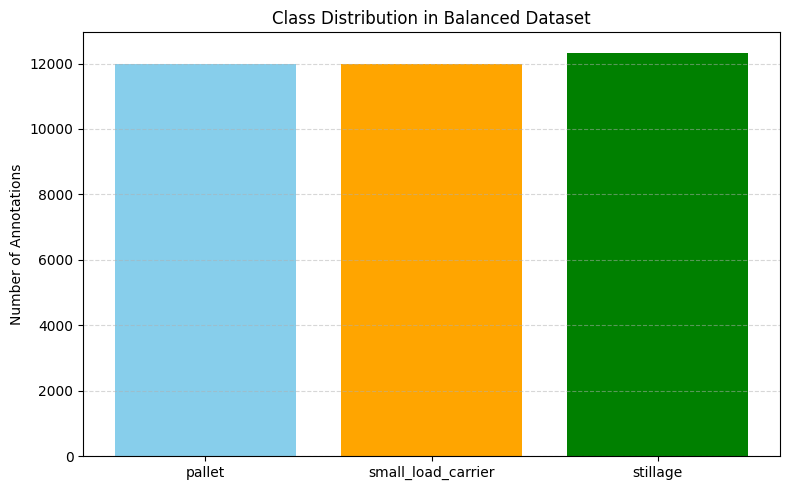

In [10]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# ========== CONFIG ==========
DATASET_ROOT = '/content/balanced_Data'  # Adjust path if needed
SPLITS = ['train', 'valid', 'test']
CLASS_NAMES = {1: 'pallet', 3: 'small_load_carrier', 4: 'stillage'}
KEEP_CLASSES = {1, 3, 4}

# ========== COUNT INSTANCES ==========
class_counts = Counter()

for split in SPLITS:
    labels_dir = os.path.join(DATASET_ROOT, split, 'labels')
    if not os.path.exists(labels_dir):
        continue

    for file in os.listdir(labels_dir):
        if not file.endswith('.txt'):
            continue
        with open(os.path.join(labels_dir, file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                cls_id = int(line.strip().split()[0])
                if cls_id in KEEP_CLASSES:
                    class_counts[cls_id] += 1

# ========== DISPLAY COUNTS ==========
print("\n📊 Class distribution:")
for cls_id in KEEP_CLASSES:
    print(f"{CLASS_NAMES[cls_id]} ({cls_id}): {class_counts[cls_id]}")

# ========== PLOT ==========
plt.figure(figsize=(8, 5))
plt.bar([CLASS_NAMES[c] for c in KEEP_CLASSES],
        [class_counts[c] for c in KEEP_CLASSES],
        color=['skyblue', 'orange', 'green'])

plt.title("Class Distribution in Balanced Dataset")
plt.ylabel("Number of Annotations")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
